Template matching based on PCA

In [1]:
# Library imports
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
import os
import napari

from image_utils import *
from template_matching import *

dicom_path = os.path.join("data", "20240119_BoneMRI_EBS24")
segmentation_path = os.path.join("boneMRI", "20240119_BoneMRI_EBS24_Segmentation.nii")

Load segmentation

The shape of the image is (100, 672, 672)


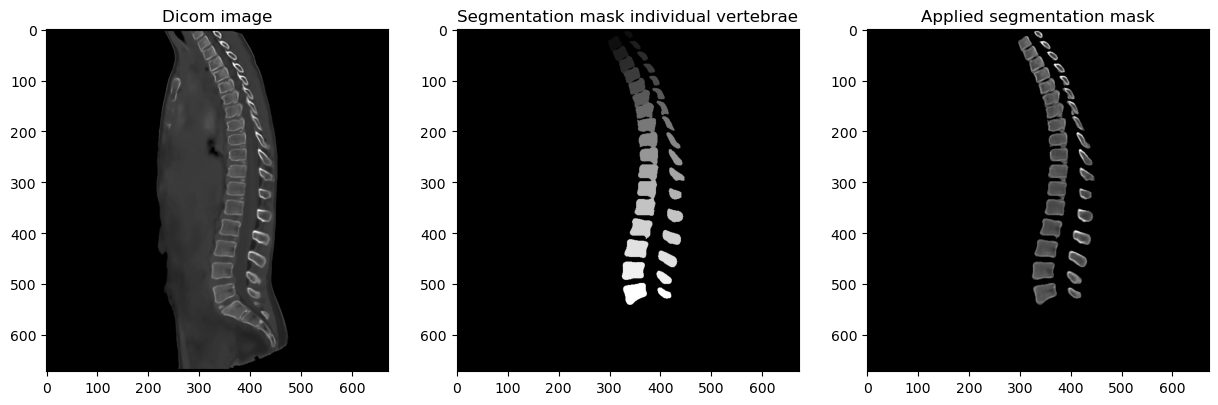

In [2]:
# Load segmentation data
segment = sitk.ReadImage(segmentation_path)
segment_data = sitk.GetArrayFromImage(segment)
segment_all = segment_data > 0

# Load dicom data and apply windowing
dicom_image = load_3d_dicom(dicom_path)
dicom_image = apply_window(dicom_image, window_level=450, window_width=1500)
segment_dicom_image = dicom_image*segment_all
print(f"The shape of the image is {dicom_image.shape}")

# Plot data 
slice_index = 50  # Middle slice along the z-axis
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(dicom_image[slice_index, ...], cmap='gray')
ax[0].set_title("Dicom image")
ax[1].imshow(segment_data[slice_index, ...], cmap='gray')
ax[1].set_title("Segmentation mask individual vertebrae")
ax[2].imshow(segment_dicom_image[slice_index, ...], cmap='gray')
ax[2].set_title("Applied segmentation mask");

Get the euler angles

In [3]:
euler_angles = get_euler_angles(segment_data)
print(f"The euler angles are {euler_angles}")

Computed bounding box for 17 vertebra
The euler angles are {1: array([-37.09463635,   6.98711982,   3.83920669]), 2: array([-33.13364585,  -6.27623296,  -1.41588068]), 3: array([-31.18305959,  -5.02020571,  -0.21163284]), 4: array([-23.86449647,   0.73072742,  -1.68286552]), 5: array([-22.47618848,  -2.15666471,   0.41933768]), 6: array([-20.9207414 ,  -4.26021367,   0.06044576]), 7: array([-15.00635206, -11.00935146,   0.71185466]), 8: array([-10.8094524 ,  -9.60057046,  -0.59171734]), 9: array([-7.93043965,  9.69665792, -0.75581453]), 10: array([ -2.99870262, -39.49541124,  -0.15735636]), 11: array([ 0.10781795, 41.33872384,  0.19595542]), 12: array([ 0.32146193, -4.13322923, -0.25089381]), 13: array([  8.48165834, -40.55328848,  -0.35141898]), 14: array([ 11.73932402, -37.22968459,   0.72866521]), 15: array([12.28463196, -4.28694921,  0.80438242]), 16: array([ 4.28990241, -0.14976182,  0.97711205]), 17: array([-0.56541917,  1.06443256,  1.43554275])}


Make the templates for matching

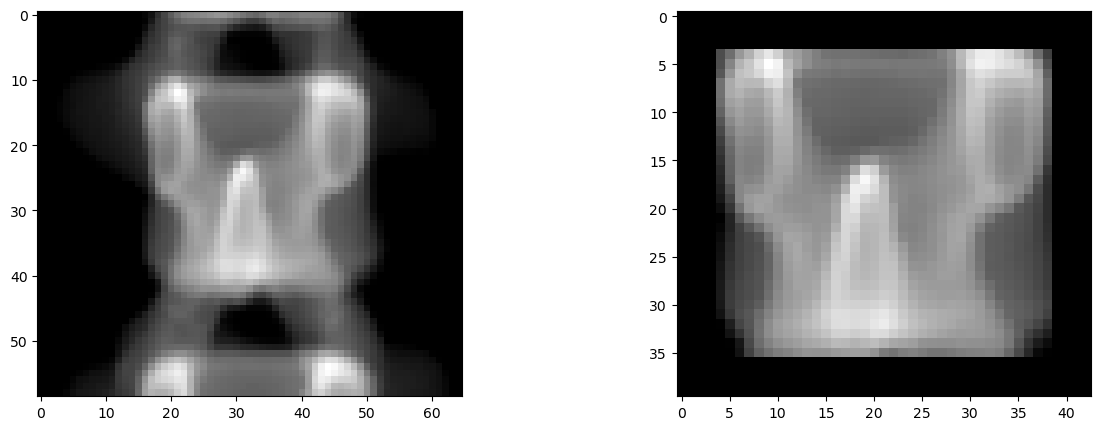

In [4]:
label = 14.0
generate_template(segment_dicom_image, segment_data, label, euler_angles)

Generate 3D input ROI

In [5]:
ROI_3D_image, ref_3D_image, rotated_image, rotated_mask = make_input_3D_ROI(segment_dicom_image, segment_data, label, euler_angles, saggital_angle=0, coronal_angle=0, axial_angle=0)    

The updated euler angles after initial rotation are:  [ 11.73932402 -37.22968459   0.72866521]


Use template matching and plot the results

Best Angles: Saggital=12.377933209662276 degrees, Coronal=0.0 degrees, Axial=0.6312274792239148 degrees


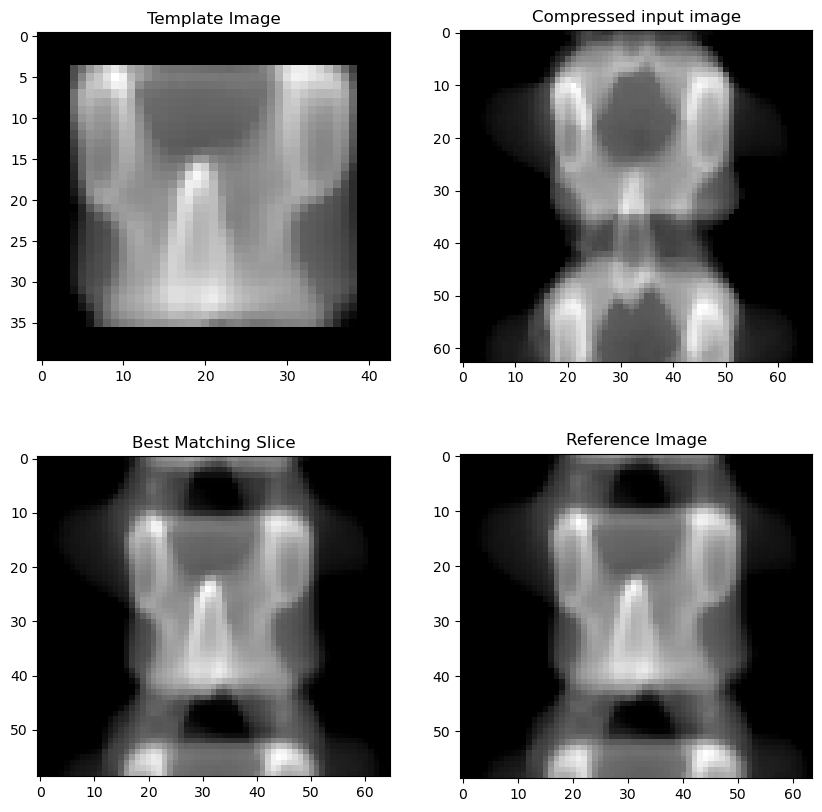

In [6]:
# Load the template from the NIfTI file
template_nii = nib.load('template_image.nii')
template = template_nii.get_fdata().astype(np.float32)

# Optimization using SciPy
bounds = [(-45, 45), (0, 0), (-15, 15)]  # Bounds the saggital, coronal, and axial angles

# Optimize the rotation angles
optimal_angles = optimize_rotation(ROI_3D_image, template, bounds)

print(f"Best Angles: Saggital={optimal_angles[0]} degrees, Coronal={optimal_angles[1]} degrees, Axial={optimal_angles[2]} degrees")

# Compress the 3D image along the z-axis
input_2d_image = compress_bonemri(ROI_3D_image, axis=2).astype(np.float32)
ref_2D_image = compress_bonemri(ref_3D_image, axis=2).astype(np.float32)

# Visualize the best matching slice
best_rotated = rotate_3D(rotated_image, sagittal_angle=optimal_angles[0], axial_angle=optimal_angles[2])
best_rotated_mask = rotate_3D(rotated_mask, sagittal_angle=optimal_angles[0], axial_angle=optimal_angles[2])
# Obtain individual segmented vertebra bbox image
best_rot_bbox_coord, best_rot_bbox_mask = compute_bbox(best_rotated_mask)
best_3D_image = best_rotated[
    best_rot_bbox_coord["z_min"]-5:best_rot_bbox_coord["z_max"]+5,
    best_rot_bbox_coord["y_min"]:best_rot_bbox_coord["y_max"],
    best_rot_bbox_coord["x_min"]:best_rot_bbox_coord["x_max"],
]

best_slice = compress_bonemri(best_3D_image, axis=2)

figure, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].imshow(np.rot90(template,3), cmap='gray')
ax[0,0].set_title("Template Image")

ax[0,1].imshow(np.rot90(input_2d_image,3), cmap='gray')
ax[0,1].set_title("Compressed input image")

ax[1,0].imshow(np.rot90(best_slice,3), cmap='gray')
ax[1,0].set_title("Best Matching Slice")

ax[1,1].imshow(np.rot90(ref_2D_image,3), cmap='gray')
ax[1,1].set_title("Reference Image")
plt.show()